# 1. 라이브러리 및 데이터

In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#시드 고정
np.random.seed(3031)

In [2]:
train = pd.read_csv("training_set.csv")
test = pd.read_csv("test_set.csv")

# 2. EDA

## 데이터 정보

In [3]:
train.shape

(55000, 172)

In [4]:
test.dtypes

ID_code     object
X1           int64
X2         float64
X3         float64
X4         float64
            ...   
X105h      float64
X105i      float64
X105j      float64
X106       float64
X107       float64
Length: 171, dtype: object

In [5]:
# ID_code 제거
train = train.drop(columns=['ID_code'])
test = test.drop(columns=['ID_code'])

In [6]:
train

,class,X1,X2,X3,X4,X5,X6,X7a,X7b,X7c,...,X105c,X105d,X105e,X105f,X105g,X105h,X105i,X105j,X106,X107
0,0,3490,0.0,8.000000e+01,212.0,0.0,0.0,0.0,0.0,0.0,...,12986.0,7612.0,17044.0,13682.0,19594.0,74564.0,5270.0,0.0,0.0,0.0
1,0,92,0.0,1.400000e+01,10.0,0.0,0.0,0.0,0.0,0.0,...,512.0,120.0,332.0,344.0,964.0,1414.0,0.0,0.0,0.0,0.0
2,0,10,0.0,1.800000e+01,2.0,4.0,6.0,0.0,0.0,0.0,...,132.0,22.0,32.0,24.0,26.0,54.0,0.0,0.0,0.0,0.0
3,0,390692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,156758,NaN,2.130706e+09,408.0,0.0,0.0,0.0,0.0,0.0,...,1652370.0,852932.0,1494660.0,1026644.0,779338.0,480460.0,784792.0,33582.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0,23910,NaN,8.680000e+02,694.0,0.0,0.0,0.0,5932.0,217980.0,...,341764.0,81988.0,151692.0,128676.0,112698.0,144182.0,596.0,0.0,0.0,0.0
54996,0,170978,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1461416.0,522106.0,821572.0,632884.0,715346.0,3099426.0,194594.0,0.0,NaN,NaN
54997,0,14,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,124.0,22.0,48.0,56.0,12.0,18.0,0.0,0.0,0.0,0.0
54998,1,437486,0.0,NaN,NaN,0.0,0.0,0.0,96944.0,981638.0,...,1088628.0,576962.0,1260296.0,1452080.0,2642866.0,2303888.0,91546.0,0.0,0.0,0.0


## 결측치 확인

<Axes: >

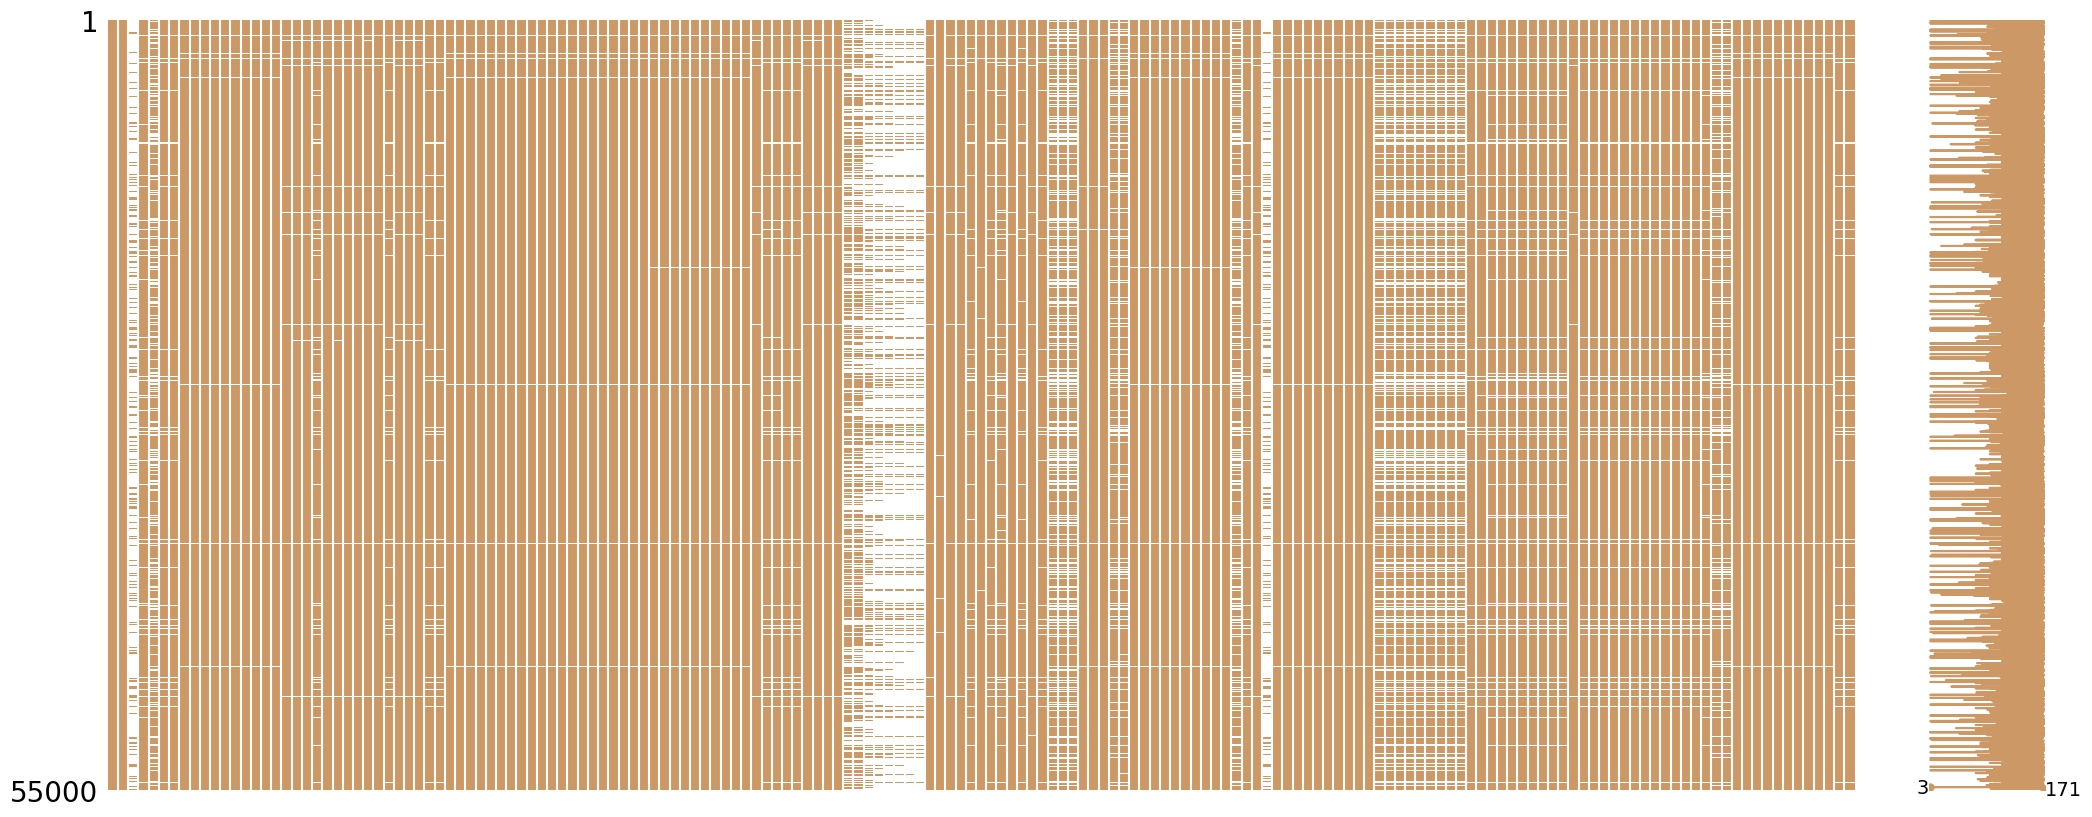

In [7]:
msno.matrix(train, color=(0.8,0.6,0.4))

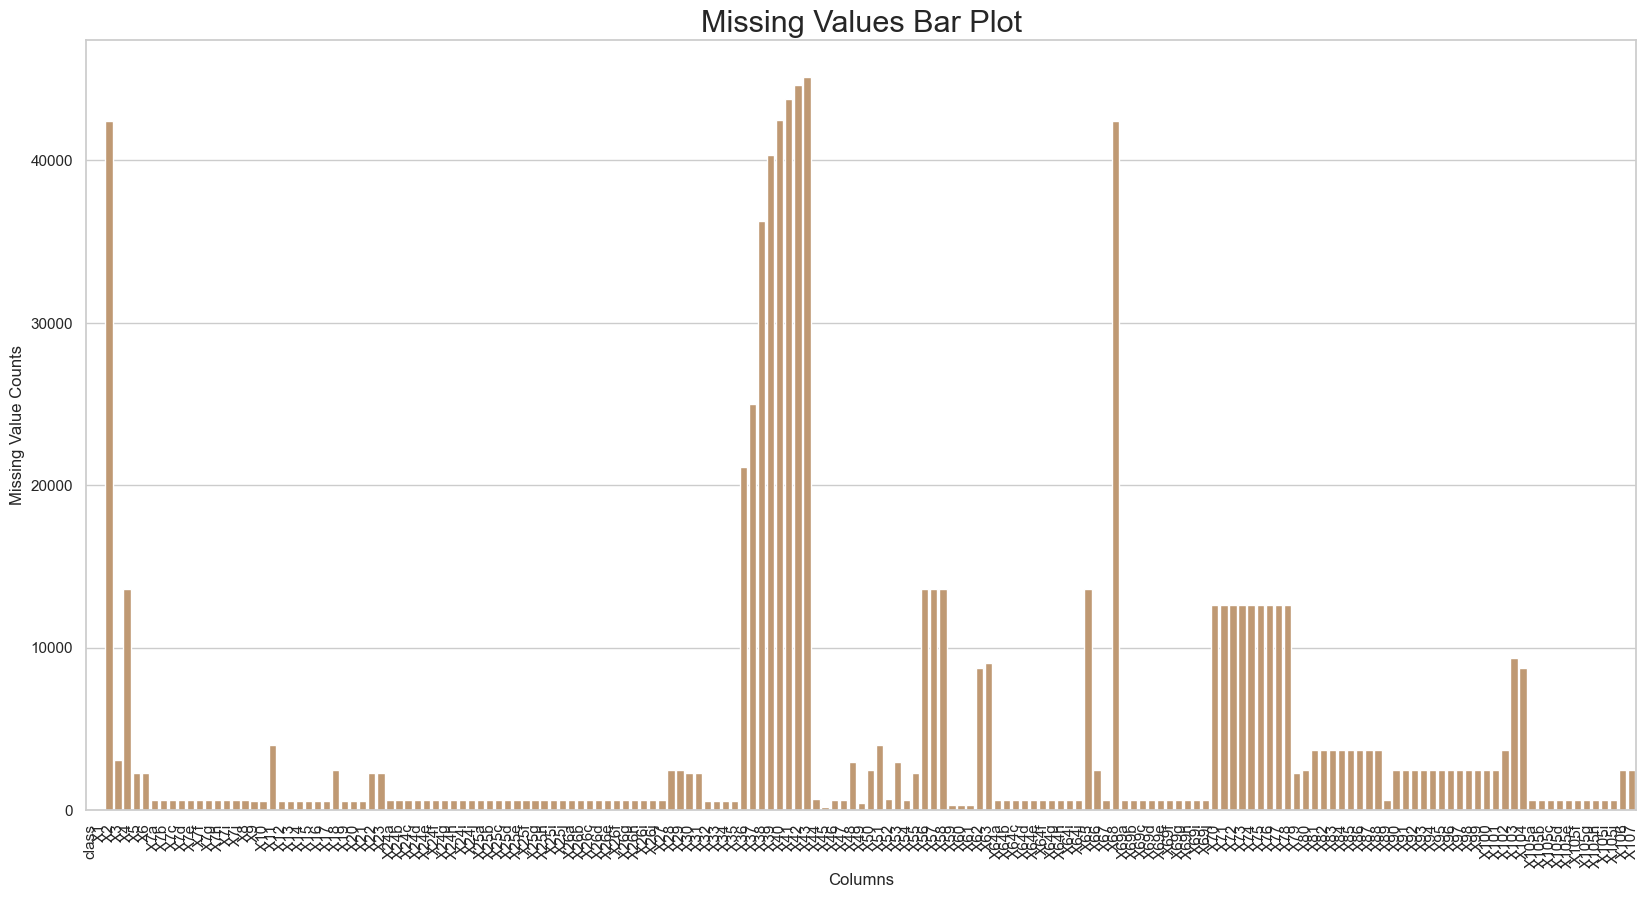

In [8]:
missing = train.isnull().sum()
# missing = missing[missing > 0]
# missing.sort_values(inplace=True)

sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
sns.barplot(x=missing.index, y=missing, color=(0.8,0.6,0.4))
plt.title("Missing Values Bar Plot", fontsize = 22)
plt.xlabel("Columns")
plt.ylabel("Missing Value Counts")
plt.xticks(rotation=90)
plt.show()

In [9]:
#결측 비율 확인 함수
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [10]:
miss = missing_data(train)
miss

,class,X1,X2,X3,X4,X5,X6,X7a,X7b,X7c,...,X105c,X105d,X105e,X105f,X105g,X105h,X105i,X105j,X106,X107
Total,0,0,42415,3061,13596,2277,2277,609,609,609,...,610,610,610,610,610,610,610,610,2484,2483
Percent,0.0,0.0,77.118182,5.565455,24.72,4.14,4.14,1.107273,1.107273,1.107273,...,1.109091,1.109091,1.109091,1.109091,1.109091,1.109091,1.109091,1.109091,4.516364,4.514545
Types,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [11]:
#결측 비율 20% 이상 변수 확인
second_row = miss.iloc[1]
second_row[second_row > 20].to_frame().T

,X2,X4,X36,X37,X38,X39,X40,X41,X42,X43,...,X68,X70,X71,X72,X73,X74,X75,X76,X77,X78
Percent,77.118182,24.72,38.452727,45.496364,65.938182,73.390909,77.24,79.574545,81.2,82.110909,...,77.118182,22.969091,22.969091,22.969091,22.969091,22.969091,22.969091,22.969091,22.969091,22.969091


### 행 결측치 시각화(20% 이상 결측치가 있는 행)

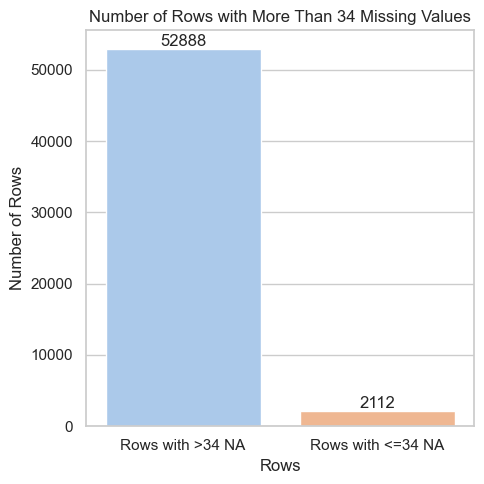

In [12]:
# 행 결측치 시각화
missing_values_count_per_row = train.isnull().sum(axis=1)

# Count the number of rows with more than 34 missing values
rows_with_more_than_34_na = (missing_values_count_per_row > 2).sum()

# Count the number of rows with less than or equal to 34 missing values
rows_with_less_or_equal_34_na = (missing_values_count_per_row <= 2).sum()

# Visualization using seaborn
plt.figure(figsize=(5, 5))

# Plot barplot
sns.barplot(x=['Rows with >34 NA', 'Rows with <=34 NA'], y=[rows_with_more_than_34_na, rows_with_less_or_equal_34_na], palette="pastel")
plt.xlabel('Rows')
plt.ylabel('Number of Rows')
plt.title('Number of Rows with More Than 34 Missing Values')

# Add labels to the bars
for idx, value in enumerate([rows_with_more_than_34_na, rows_with_less_or_equal_34_na]):
    plt.text(idx, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 클래스 분포 확인

<Axes: xlabel='class', ylabel='count'>

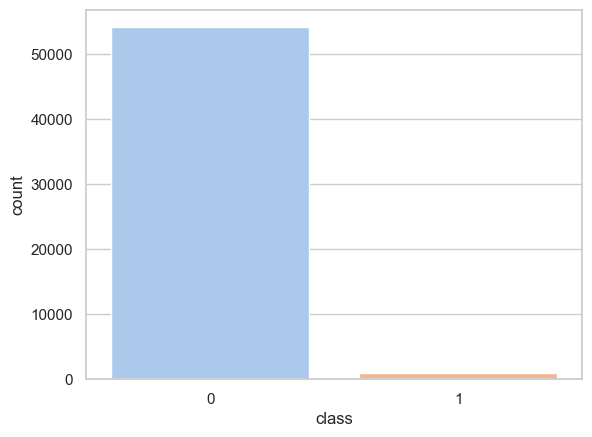

In [13]:
sns.countplot(x="class", data=train, palette ='pastel')

<Axes: ylabel='class'>

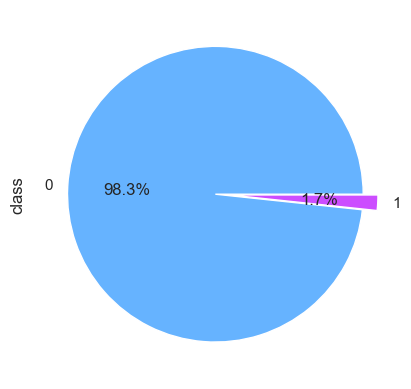

In [14]:
colors = [(0.4,0.7,1), (0.8,0.3,1)]

train['class'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',shadow=False, colors=colors)

## 변수별 상관관계 확인

Text(0.5, 1.0, 'Correlation of Variables')

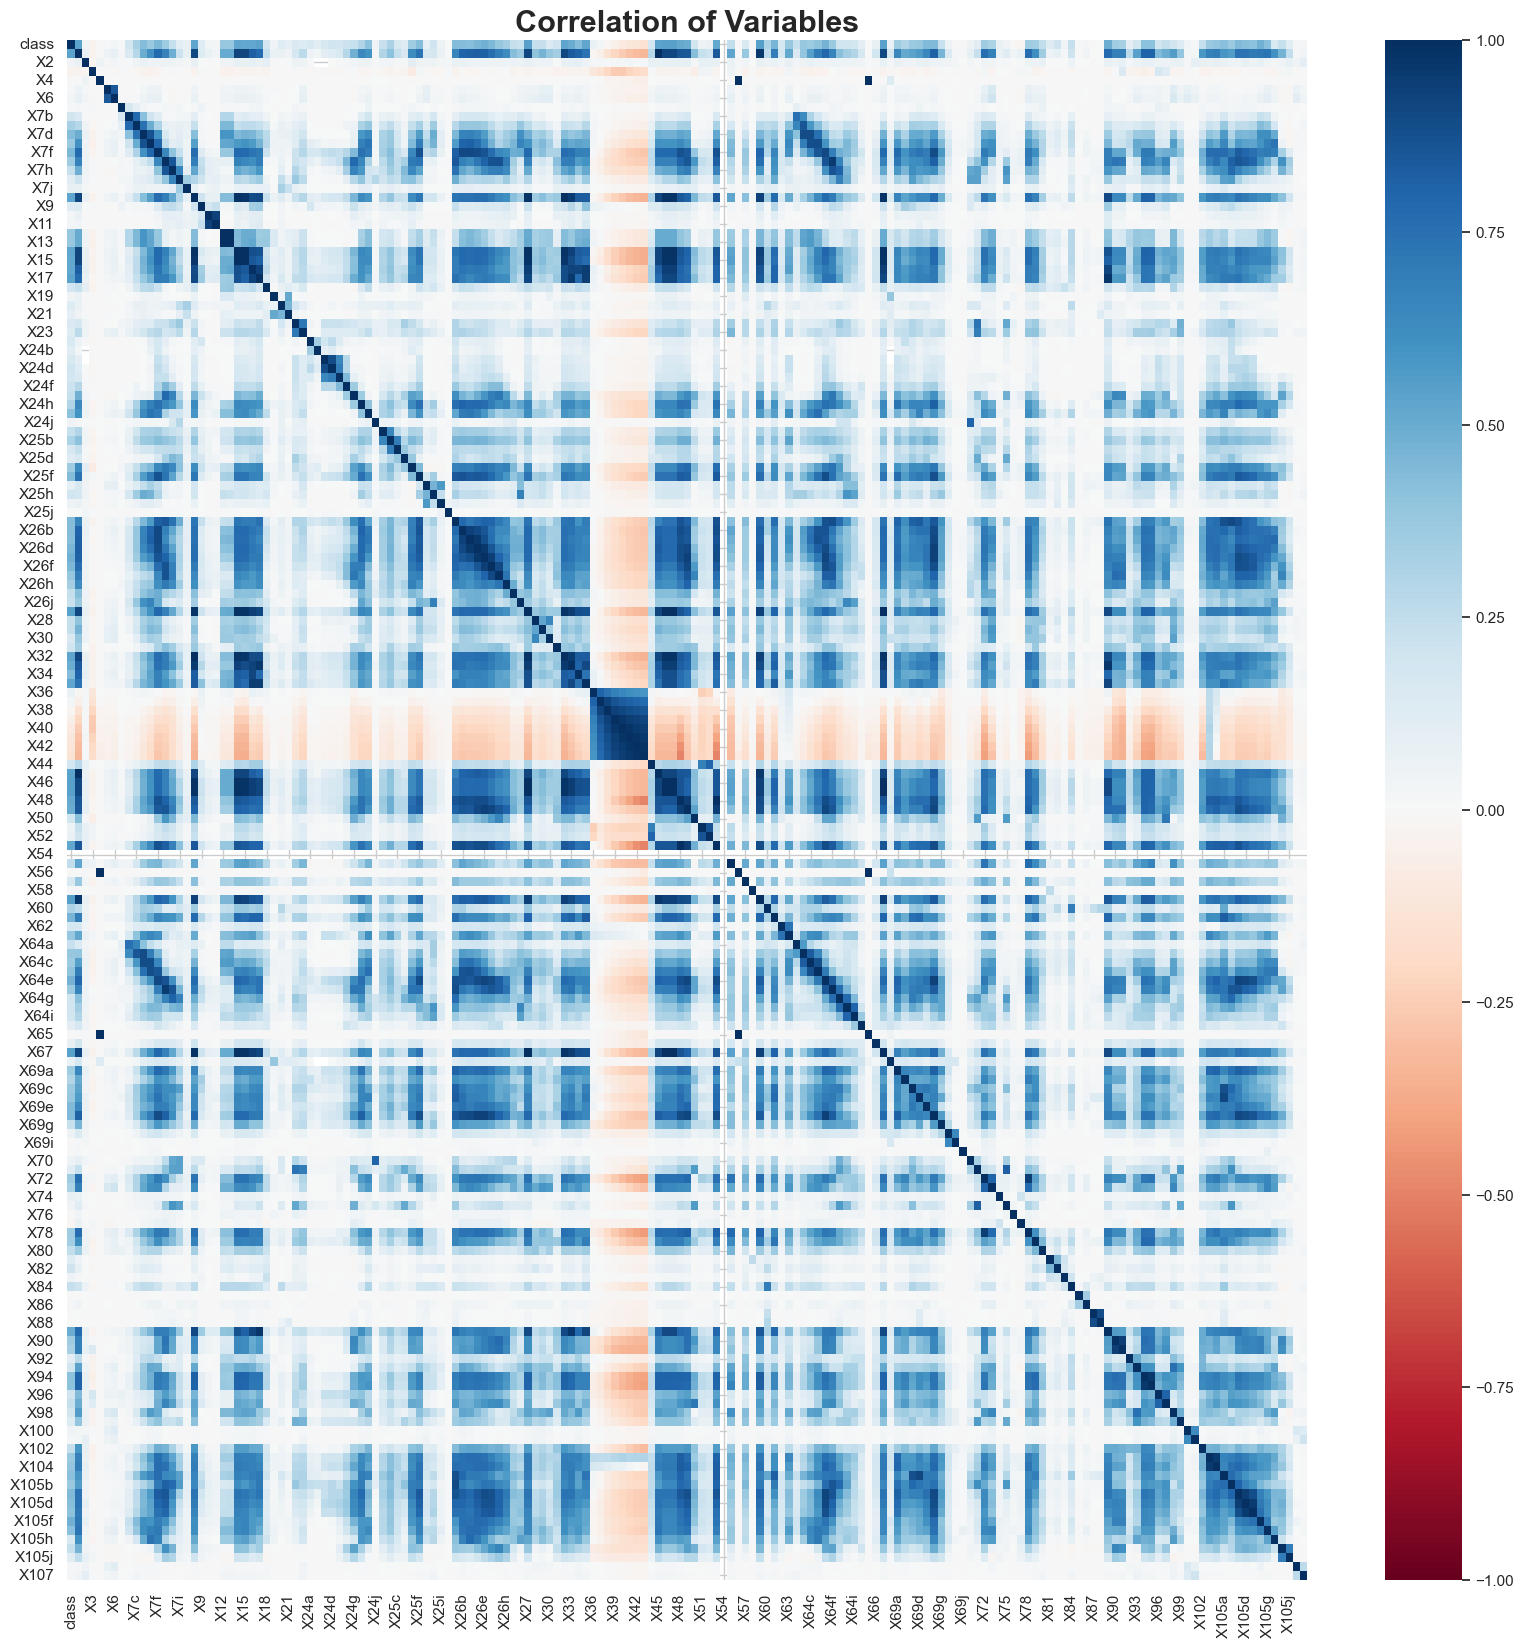

In [15]:
num_var = train.select_dtypes(include = ['int64', 'float64'])
num_corr = num_var.corr()

plt.figure(figsize=(20, 20), dpi=100)
sns.heatmap(num_corr, annot=False, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.title("Correlation of Variables", fontweight="bold", fontsize = 22)

## 변수 분포 확인

In [16]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(17,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show();

<Figure size 640x480 with 0 Axes>

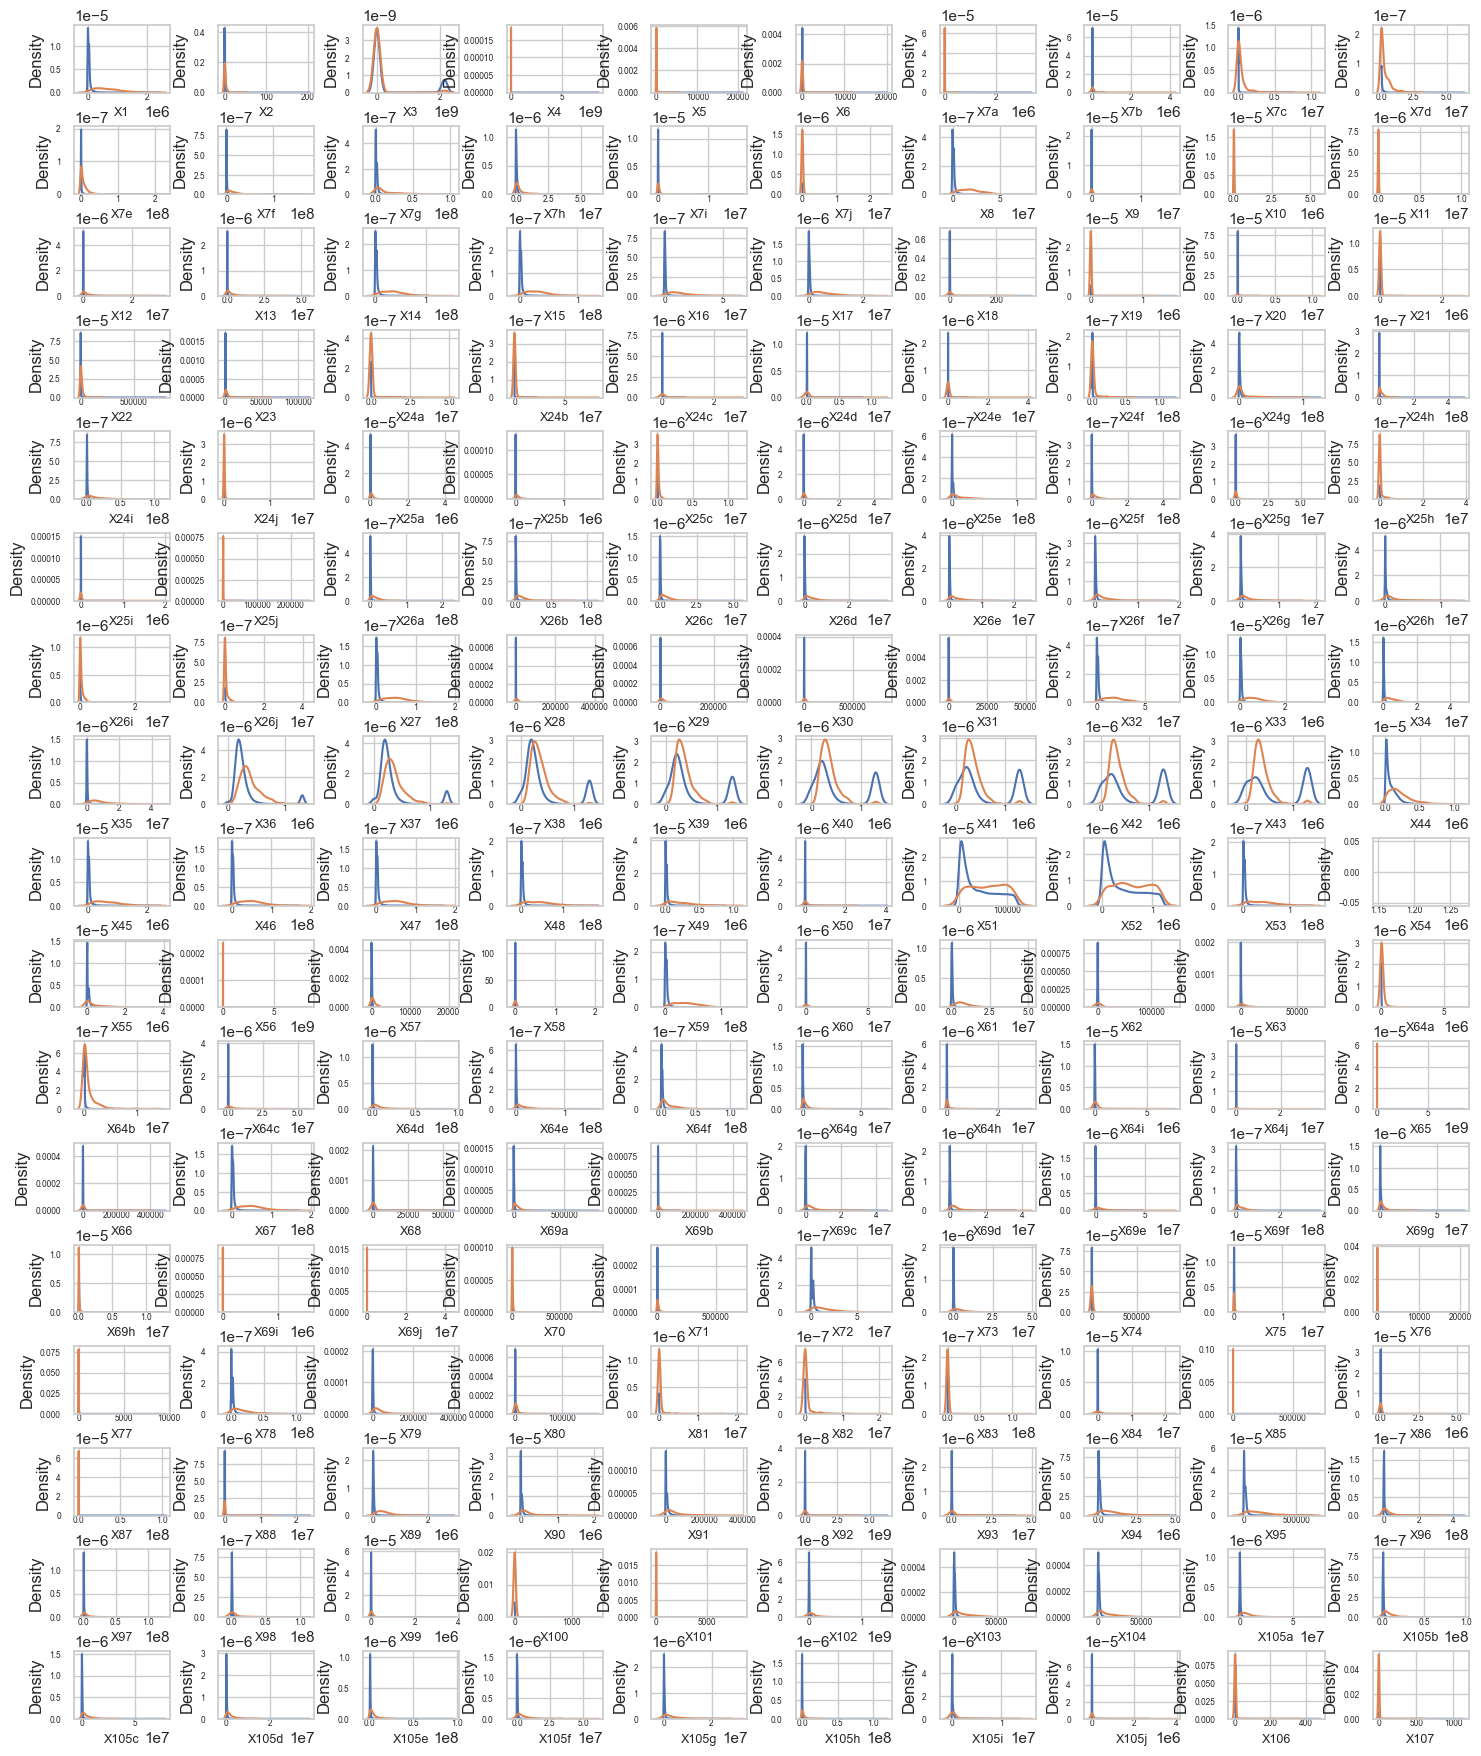

In [17]:
t0 = train.loc[train['class'] == 0]
t1 = train.loc[train['class'] == 1]
features = train.columns.values[1:171]
plot_feature_distribution(t0, t1, '0', '1', features)

여-존슨 변환시 분포가 더 잘 드러나므로 로그변환 후 진행

변환을 위해 결측치 비율 20% 이상 열 제거, 분포 확인을 위해 complete set 사용하여 분포 확인

In [18]:
# 변환을 위해 결측치 비율 20% 이상 열 제거, 그 다음 결측치 있는 행 제거
def remove_columns_with_high_missing(train_data, threshold=20):
    columns_to_remove = train_data.columns[train_data.isnull().mean() * 100 >= threshold]
    train_data_cleaned = train_data.drop(columns=columns_to_remove)
    return train_data_cleaned

def remove_rows_with_high_missing(data, missing_threshold=1):
    rows_to_remove = data.isnull().sum(axis=1) >= missing_threshold
    data = data[~rows_to_remove]
    return data

In [19]:
train_dist = remove_columns_with_high_missing(train)
train_dist = remove_rows_with_high_missing(train)

train_dist

,class,X1,X2,X3,X4,X5,X6,X7a,X7b,X7c,...,X105c,X105d,X105e,X105f,X105g,X105h,X105i,X105j,X106,X107
68,0,1675586,0.0,2.618000e+03,2358.0,0.0,0.0,0.0,42.0,498252.0,...,7570716.0,3600070.0,16744132.0,3572644.0,5831854.0,34926306.0,1626932.0,0.0,0.0,0.0
155,1,195268,0.0,4.720000e+02,380.0,0.0,0.0,0.0,0.0,69162.0,...,945840.0,403650.0,835958.0,882110.0,2056392.0,3236850.0,55652.0,0.0,0.0,0.0
191,0,150372,0.0,2.130706e+09,2156.0,0.0,0.0,0.0,0.0,0.0,...,562102.0,278236.0,560110.0,798346.0,1458236.0,1167122.0,42632.0,2.0,0.0,0.0
217,0,187998,0.0,2.338000e+03,1404.0,0.0,0.0,0.0,0.0,0.0,...,526334.0,246500.0,569974.0,512280.0,925678.0,3687272.0,56446.0,0.0,0.0,0.0
244,0,301088,2.0,8.900000e+02,724.0,0.0,0.0,0.0,0.0,27868.0,...,1107304.0,648390.0,1510228.0,1255690.0,3552382.0,4833612.0,72080.0,16.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54312,1,354598,0.0,0.000000e+00,4648.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54651,0,100916,4.0,8.580000e+02,802.0,0.0,0.0,0.0,0.0,0.0,...,1303224.0,1586200.0,373208.0,294808.0,1311848.0,23592.0,542.0,0.0,0.0,0.0
54728,0,152320,2.0,2.130706e+09,976.0,0.0,0.0,0.0,0.0,0.0,...,812488.0,427122.0,1165570.0,670038.0,773326.0,2602568.0,186036.0,0.0,0.0,0.0
54876,0,186570,0.0,2.208000e+03,2056.0,458.0,518.0,0.0,0.0,0.0,...,495296.0,272378.0,425234.0,676860.0,5868044.0,254158.0,2836.0,32.0,0.0,0.0


In [20]:
cl_col = train_dist['class']
train_dist = train_dist.drop('class', axis=1)

yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')
for column in train_dist.columns:
    train_dist[column] = yeo_johnson_transformer.fit_transform(train_dist[column].values.reshape(-1, 1))
    
train_dist = pd.concat([cl_col, train_dist], axis = 1)
train_dist

,class,X1,X2,X3,X4,X5,X6,X7a,X7b,X7c,...,X105c,X105d,X105e,X105f,X105g,X105h,X105i,X105j,X106,X107
68,0,3.674644,-0.457540,0.231521,1.292224,-0.509694,-0.509675,-0.096404,3.072664,1.645194,...,2.225541,2.217737,3.227184,1.311194,1.248769,2.561605,3.066515,-0.645262,-0.215041,-0.228748
155,1,-0.255471,-0.457540,-0.219642,-0.200646,-0.509694,-0.509675,-0.096404,-0.324994,1.590810,...,0.298032,0.237175,0.308214,0.317537,0.475582,0.858344,0.787181,-0.645262,-0.215041,-0.228748
191,0,-0.601172,-0.457540,2.061887,1.200621,-0.509694,-0.509675,-0.096404,-0.324994,-0.660361,...,-0.033441,0.004164,0.063912,0.258850,0.262490,0.336584,0.655400,0.646684,-0.215041,-0.228748
217,0,-0.307133,-0.457540,0.203970,0.791238,-0.509694,-0.509675,-0.096404,-0.324994,-0.660361,...,-0.072007,-0.066656,0.074039,0.014608,0.007954,0.932722,0.794348,-0.645262,-0.215041,-0.228748
244,0,0.371370,2.172562,-0.043916,0.245054,-0.509694,-0.509675,-0.096404,-0.324994,1.554873,...,0.408270,0.570857,0.719056,0.537175,0.855421,1.093397,0.920713,1.459852,-0.215041,-0.228748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54312,1,0.626983,-0.457540,-2.631247,2.062898,-0.509694,-0.509675,-0.096404,-0.324994,-0.660361,...,-2.107000,-2.080994,-2.085914,-2.024298,-2.001054,-1.891911,-1.779016,-0.645262,-0.215041,-0.228748
54651,0,-1.085968,2.206583,-0.053774,0.323202,-0.509694,-0.509675,-0.096404,-0.324994,-0.660361,...,0.527416,1.333147,-0.159067,-0.254643,0.200577,-0.929918,-0.851571,-0.645262,-0.215041,-0.228748
54728,0,-0.584680,2.172562,2.061887,0.479346,-0.509694,-0.509675,-0.096404,-0.324994,-0.660361,...,0.196219,0.274713,0.531290,0.159209,-0.084895,0.737960,1.461687,-0.645262,-0.215041,-0.228748
54876,0,-0.317454,-0.457540,0.189921,1.152933,1.973300,1.962220,-0.096404,-0.324994,-0.660361,...,-0.107037,-0.008451,-0.089950,0.164854,1.253999,-0.274017,-0.402682,1.592152,-0.215041,-0.228748


<Figure size 640x480 with 0 Axes>

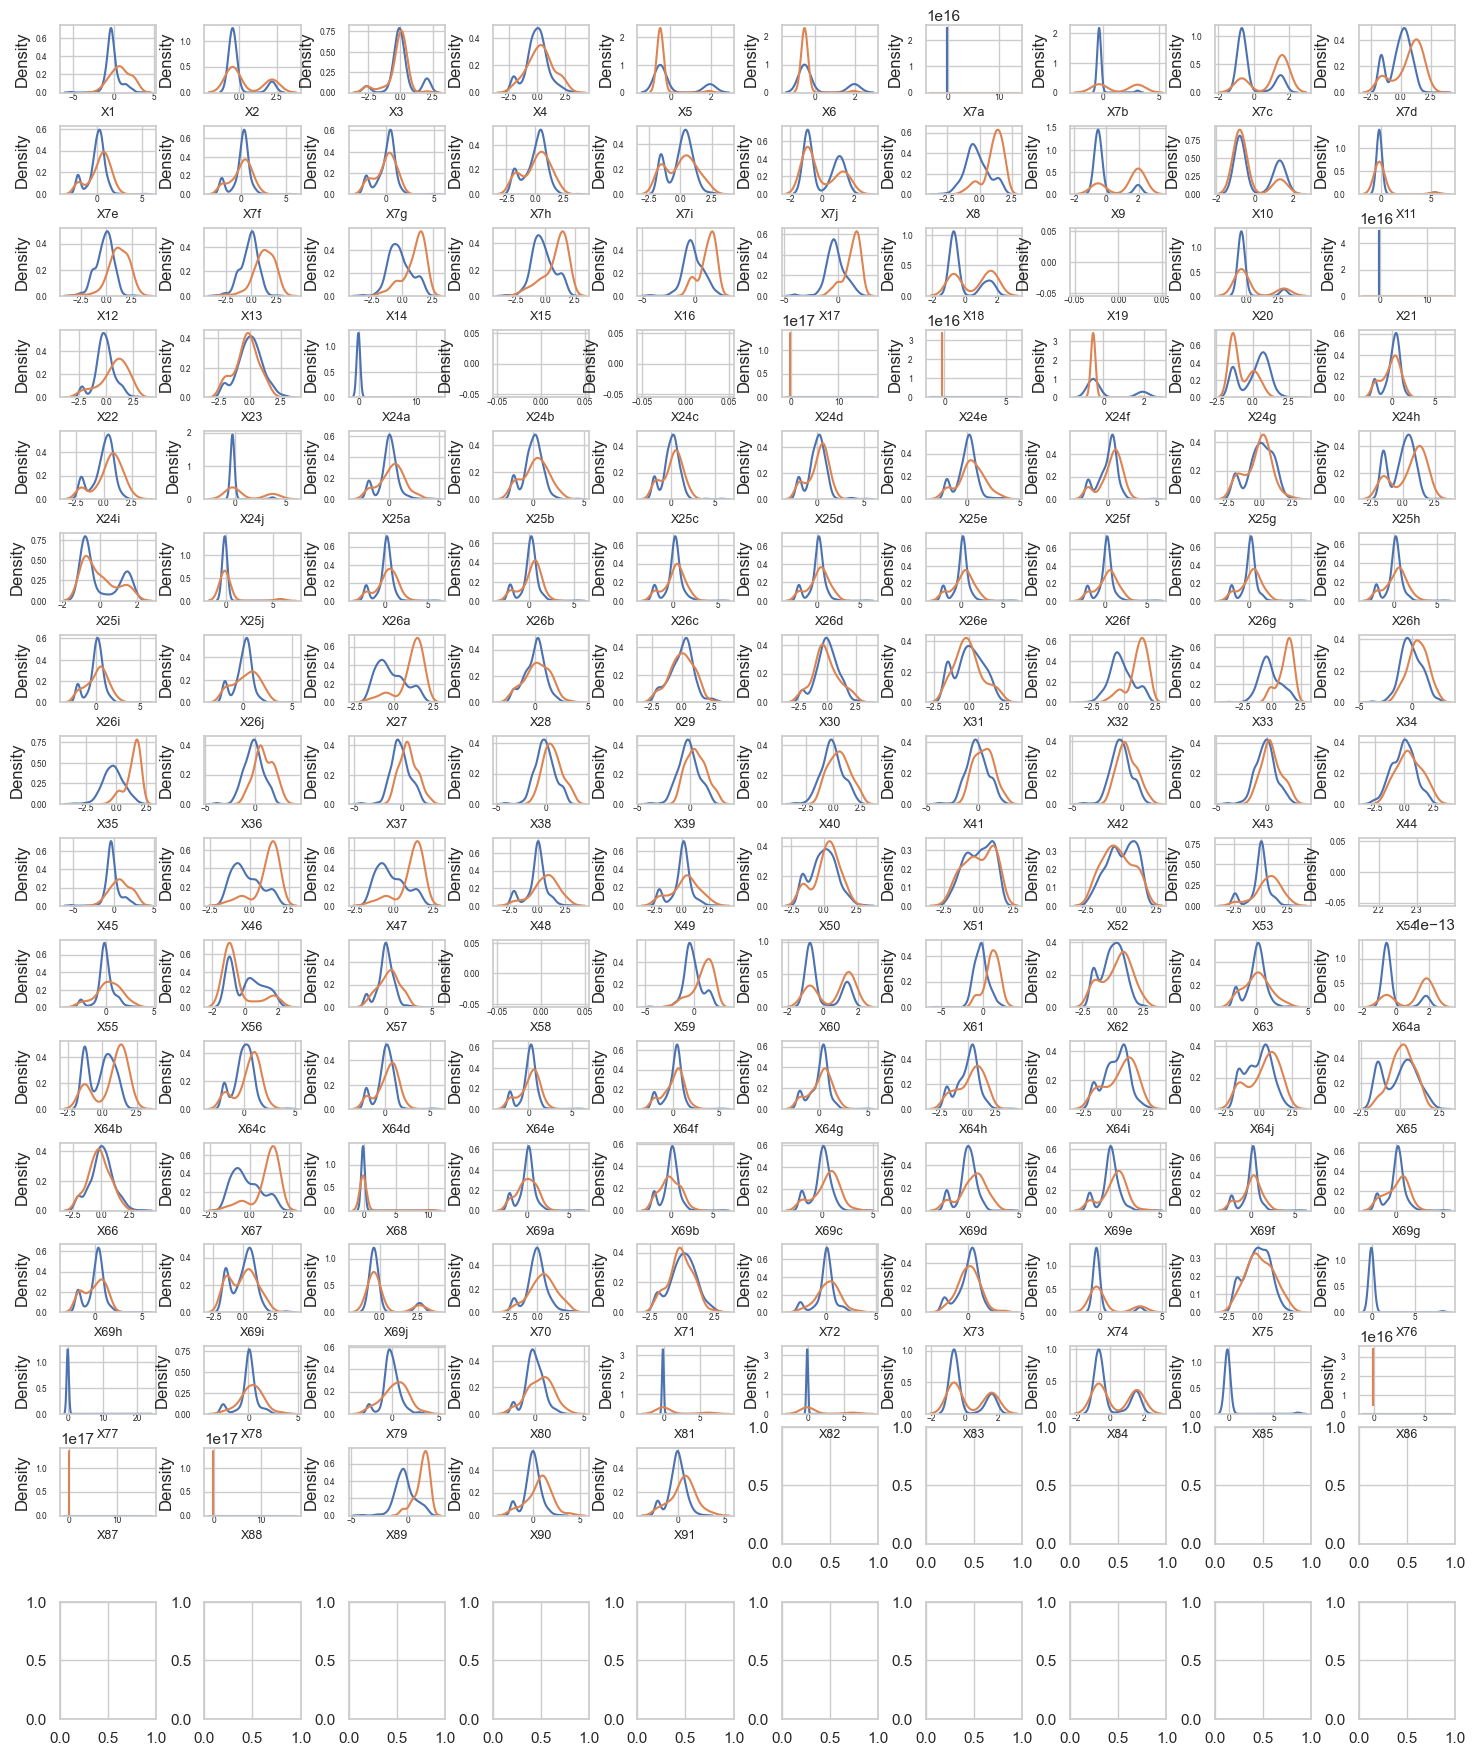

In [21]:
t0 = train_dist.loc[train_dist['class'] == 0]
t1 = train_dist.loc[train_dist['class'] == 1]
features = train_dist.columns.values[1:146]
plot_feature_distribution(t0, t1, '0', '1', features)